In [8]:
import numpy as np, os, sys, h5py
import pandas as pd

sys.path.append("..")
import src
from src.models import JacobianRegularizedModel
from src.regularizers import SpectralNormRegularizer

import logomaker
from logomaker import Logo
import tfomics
from tfomics import moana, impress

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [97]:
data_path = '../data' 
filepath = os.path.join(data_path, 'synthetic_code_dataset.h5')
with h5py.File(filepath, 'r') as dataset:
    x_train = np.array(dataset['X_train']).astype(np.float32)
    y_train = np.array(dataset['Y_train']).astype(np.float32)
    x_valid = np.array(dataset['X_valid']).astype(np.float32)
    y_valid = np.array(dataset['Y_valid']).astype(np.int32)
    x_test = np.array(dataset['X_test']).astype(np.float32)
    y_test = np.array(dataset['Y_test']).astype(np.int32)
    model_test = np.array(dataset['model_test']).astype(np.float32)

model_test = model_test.transpose([0,2,1])
x_train = x_train.transpose([0,2,1])
x_valid = x_valid.transpose([0,2,1])
x_test = x_test.transpose([0,2,1])
N, L, A = x_train.shape

dataset = {}
dataset['train'] = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000)
dataset['valid'] = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).shuffle(10000)
dataset['test'] = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(10000)
del x_train, y_train, x_test, y_test, x_valid, y_valid

### Define model

In [100]:
def cnn_dist(
            input_shape, 
            num_labels, 
            activation='relu', 
            units=[24, 32, 48, 64, 96], 
            dropout=[0.1, 0.2, 0.3, 0.4, 0.5], 
            kernel_regularizer=None,
            logits_only=False,
            name='model',
            ):        
    # input layer
    inputs = tfk.layers.Input(shape=input_shape)

    # layer 1
    nn = tfk.layers.Conv1D(
                        filters=units[0],
                        kernel_size=19,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(inputs)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation(activation)(nn)
    nn = activation(nn)
    nn = tfk.layers.Dropout(dropout[0])(nn)

    nn = tfk.layers.Conv1D(
                        filters=units[1],
                        kernel_size=7,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.Dropout(dropout[1])(nn)
    nn = tfk.layers.MaxPool1D(pool_size=4)(nn)

    # layer 2
    nn = tfk.layers.Conv1D(
                        filters=units[2],
                        kernel_size=5,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.MaxPool1D(pool_size=4)(nn)
    nn = tfk.layers.Dropout(dropout[2])(nn)

    # layer 3
    nn = tfk.layers.Conv1D(
                        filters=units[3],
                        kernel_size=5,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.MaxPool1D(pool_size=4)(nn)
    nn = tfk.layers.Dropout(dropout[3])(nn)

    # layer 4 - Fully-connected 
    nn = tfk.layers.Flatten()(nn)
    nn = tfk.layers.Dense(
                        units[4],
                        activation=None,
                        use_bias=True,
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.Dropout(dropout[4])(nn)

    # Output layer 
    logits = tfk.layers.Dense(num_labels, name='logits')(nn)
    if logits_only:
        return tfk.Model(inputs, logits, name=name)
    else:
        outputs = tfk.layers.Activation('sigmoid', name='probabilities')(logits)
        return tfk.Model(inputs, outputs, name=name)

### Train model - no regularization

In [8]:
# define model
simplemodel = cnn_dist(input_shape=(L,A), num_labels=1, activation='relu', logits_only=False)

# set up optimizer and metrics
acc = tfk.metrics.BinaryAccuracy(name='acc')
auroc = tfk.metrics.AUC(curve='ROC', name='auroc')
aupr = tfk.metrics.AUC(curve='PR', name='aupr')
optimizer = tfk.optimizers.Adam(learning_rate=0.001)
loss = tfk.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
simplemodel.compile(optimizer=optimizer, loss=loss, metrics=[acc, auroc, aupr], )

# early stopping callback
es_callback = tfk.callbacks.EarlyStopping(monitor='val_auroc', 
                                            patience=10, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                                factor=0.2,
                                                patience=4, 
                                                min_lr=1e-7,
                                                mode='max',
                                                verbose=1) 

# train model
batchsize = 32
epochs = 100
history = simplemodel.fit(dataset['train'].batch(batchsize), 
                            epochs=epochs,
                            validation_data=dataset['valid'].batch(batchsize), 
                            callbacks=[es_callback, reduce_lr])

Epoch 1/100
438/438 [==============================] - 9s 17ms/step - loss: 0.6515 - acc: 0.6563 - auroc: 0.7121 - aupr: 0.6918 - val_loss: 0.6494 - val_acc: 0.6155 - val_auroc: 0.8126 - val_aupr: 0.7892
Epoch 2/100
438/438 [==============================] - 7s 16ms/step - loss: 0.5410 - acc: 0.7314 - auroc: 0.8035 - aupr: 0.7842 - val_loss: 0.5321 - val_acc: 0.7260 - val_auroc: 0.8602 - val_aupr: 0.8556
Epoch 3/100
438/438 [==============================] - 7s 16ms/step - loss: 0.4913 - acc: 0.7646 - auroc: 0.8433 - aupr: 0.8345 - val_loss: 0.4635 - val_acc: 0.7820 - val_auroc: 0.8813 - val_aupr: 0.8815
Epoch 4/100
438/438 [==============================] - 7s 17ms/step - loss: 0.4496 - acc: 0.7912 - auroc: 0.8713 - aupr: 0.8634 - val_loss: 0.4059 - val_acc: 0.8305 - val_auroc: 0.9040 - val_aupr: 0.9020
Epoch 5/100
438/438 [==============================] - 7s 17ms/step - loss: 0.4129 - acc: 0.8147 - auroc: 0.8928 - aupr: 0.8879 - val_loss: 0.3691 - val_acc: 0.8385 - val_auroc: 0.9249


Epoch 00040: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 41/100
438/438 [==============================] - 8s 18ms/step - loss: 0.1389 - acc: 0.9469 - auroc: 0.9878 - aupr: 0.9872 - val_loss: 0.1837 - val_acc: 0.9285 - val_auroc: 0.9825 - val_aupr: 0.9794
Epoch 42/100
438/438 [==============================] - 8s 18ms/step - loss: 0.1334 - acc: 0.9476 - auroc: 0.9887 - aupr: 0.9882 - val_loss: 0.1866 - val_acc: 0.9275 - val_auroc: 0.9825 - val_aupr: 0.9794
Epoch 43/100
438/438 [==============================] - 8s 19ms/step - loss: 0.1313 - acc: 0.9482 - auroc: 0.9891 - aupr: 0.9885 - val_loss: 0.1940 - val_acc: 0.9270 - val_auroc: 0.9827 - val_aupr: 0.9798
Epoch 44/100
438/438 [==============================] - 8s 18ms/step - loss: 0.1268 - acc: 0.9517 - auroc: 0.9897 - aupr: 0.9887 - val_loss: 0.1922 - val_acc: 0.9265 - val_auroc: 0.9825 - val_aupr: 0.9795

Epoch 00044: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 45/100
438/

### Train model - spectral regularization

In [16]:
lmbda=1e-2
n_iter=20
kernel_regularizer = SpectralNormRegularizer(lmbda, n_iter)

# define model
snregmodel = cnn_dist(
            input_shape=(L,A), num_labels=1, activation='relu', logits_only=False, 
          kernel_regularizer=kernel_regularizer
                    )

# set up optimizer and metrics
acc = tfk.metrics.BinaryAccuracy(name='acc')
auroc = tfk.metrics.AUC(curve='ROC', name='auroc')
aupr = tfk.metrics.AUC(curve='PR', name='aupr')
optimizer = tfk.optimizers.Adam(learning_rate=0.001)
loss = tfk.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
snregmodel.compile(optimizer=optimizer, loss=loss, metrics=[acc, auroc, aupr], )

# early stopping callback
es_callback = tfk.callbacks.EarlyStopping(monitor='val_auroc', 
                                            patience=10, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                                factor=0.2,
                                                patience=4, 
                                                min_lr=1e-7,
                                                mode='max',
                                                verbose=1) 

# train model
batchsize = 32
epochs = 100
history = snregmodel.fit(dataset['train'].batch(batchsize), 
                            epochs=epochs,
                            validation_data=dataset['valid'].batch(batchsize), 
                            callbacks=[es_callback, reduce_lr])

Epoch 1/100
438/438 [==============================] - 9s 17ms/step - loss: 0.7411 - acc: 0.6486 - auroc: 0.7064 - aupr: 0.6839 - val_loss: 0.6268 - val_acc: 0.7335 - val_auroc: 0.8128 - val_aupr: 0.7916
Epoch 2/100
438/438 [==============================] - 7s 16ms/step - loss: 0.6165 - acc: 0.7331 - auroc: 0.8045 - aupr: 0.7850 - val_loss: 0.6164 - val_acc: 0.7110 - val_auroc: 0.8620 - val_aupr: 0.8575
Epoch 3/100
438/438 [==============================] - 8s 18ms/step - loss: 0.5697 - acc: 0.7634 - auroc: 0.8373 - aupr: 0.8250 - val_loss: 0.5784 - val_acc: 0.7400 - val_auroc: 0.8805 - val_aupr: 0.8775
Epoch 4/100
438/438 [==============================] - 8s 18ms/step - loss: 0.5447 - acc: 0.7746 - auroc: 0.8536 - aupr: 0.8421 - val_loss: 0.5136 - val_acc: 0.8065 - val_auroc: 0.8916 - val_aupr: 0.8901
Epoch 5/100
438/438 [==============================] - 8s 18ms/step - loss: 0.5145 - acc: 0.7966 - auroc: 0.8731 - aupr: 0.8662 - val_loss: 0.4804 - val_acc: 0.8165 - val_auroc: 0.9110

438/438 [==============================] - 8s 18ms/step - loss: 0.2640 - acc: 0.9257 - auroc: 0.9782 - aupr: 0.9762 - val_loss: 0.2963 - val_acc: 0.9080 - val_auroc: 0.9813 - val_aupr: 0.9795
Epoch 42/100
438/438 [==============================] - 8s 18ms/step - loss: 0.2730 - acc: 0.9222 - auroc: 0.9760 - aupr: 0.9746 - val_loss: 0.3004 - val_acc: 0.9175 - val_auroc: 0.9828 - val_aupr: 0.9809

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 43/100
438/438 [==============================] - 8s 18ms/step - loss: 0.2592 - acc: 0.9261 - auroc: 0.9790 - aupr: 0.9784 - val_loss: 0.2559 - val_acc: 0.9350 - val_auroc: 0.9833 - val_aupr: 0.9816
Epoch 44/100
438/438 [==============================] - 8s 18ms/step - loss: 0.2477 - acc: 0.9312 - auroc: 0.9810 - aupr: 0.9804 - val_loss: 0.2467 - val_acc: 0.9360 - val_auroc: 0.9843 - val_aupr: 0.9827
Epoch 45/100
438/438 [==============================] - 8s 18ms/step - loss: 0.2323 - acc: 0.9364 - auroc: 0.98

### Train model - jacobian reg. 

In [44]:
# define model
jacregmodel = JacobianRegularizedModel(
                model=cnn_dist(input_shape=(L,A), num_labels=1, activation='relu', logits_only=True,)
                                    )

# set up optimizer and metrics
acc = tfk.metrics.BinaryAccuracy(name='acc')
auroc = tfk.metrics.AUC(curve='ROC', name='auroc')
aupr = tfk.metrics.AUC(curve='PR', name='aupr')
optimizer = tfk.optimizers.Adam(learning_rate=0.001)
loss = tfk.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
jacregmodel.compile(optimizer=optimizer, loss=loss, metrics=[acc, auroc, aupr], beta=1e-3)

# early stopping callback
es_callback = tfk.callbacks.EarlyStopping(monitor='val_auroc', 
                                            patience=10, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                                factor=0.2,
                                                patience=4, 
                                                min_lr=1e-7,
                                                mode='max',
                                                verbose=1) 

# train model
batchsize = 32
epochs = 100
history = jacregmodel.fit(dataset['train'].batch(batchsize), 
                            epochs=epochs,
                            validation_data=dataset['valid'].batch(batchsize), 
                            callbacks=[es_callback, reduce_lr])

Epoch 1/100
438/438 [==============================] - 21s 35ms/step - loss: 0.6712 - acc: 0.6459 - auroc: 0.6990 - aupr: 0.6832 - jacobian_norm: 8.3066 - val_loss: 0.5639 - val_acc: 0.7180 - val_auroc: 0.8175 - val_aupr: 0.7991
Epoch 2/100
438/438 [==============================] - 18s 41ms/step - loss: 0.5416 - acc: 0.7321 - auroc: 0.8050 - aupr: 0.7947 - jacobian_norm: 2.2239 - val_loss: 0.4863 - val_acc: 0.7785 - val_auroc: 0.8650 - val_aupr: 0.8618
Epoch 3/100
438/438 [==============================] - 16s 37ms/step - loss: 0.4810 - acc: 0.7743 - auroc: 0.8518 - aupr: 0.8414 - jacobian_norm: 1.2644 - val_loss: 0.5075 - val_acc: 0.7405 - val_auroc: 0.8873 - val_aupr: 0.8857
Epoch 4/100
438/438 [==============================] - 16s 36ms/step - loss: 0.4476 - acc: 0.7934 - auroc: 0.8731 - aupr: 0.8660 - jacobian_norm: 1.0914 - val_loss: 0.4310 - val_acc: 0.8060 - val_auroc: 0.9041 - val_aupr: 0.9025
Epoch 5/100
438/438 [==============================] - 16s 36ms/step - loss: 0.4130 

Epoch 37/100
438/438 [==============================] - 16s 36ms/step - loss: 0.1647 - acc: 0.9366 - auroc: 0.9841 - aupr: 0.9842 - jacobian_norm: 4.2387 - val_loss: 0.1764 - val_acc: 0.9310 - val_auroc: 0.9808 - val_aupr: 0.9789
Epoch 38/100
438/438 [==============================] - 16s 36ms/step - loss: 0.1668 - acc: 0.9368 - auroc: 0.9836 - aupr: 0.9829 - jacobian_norm: 4.1520 - val_loss: 0.1952 - val_acc: 0.9215 - val_auroc: 0.9806 - val_aupr: 0.9783

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 39/100
438/438 [==============================] - 16s 37ms/step - loss: 0.1493 - acc: 0.9437 - auroc: 0.9871 - aupr: 0.9870 - jacobian_norm: 4.0031 - val_loss: 0.1764 - val_acc: 0.9300 - val_auroc: 0.9813 - val_aupr: 0.9790
Epoch 40/100
438/438 [==============================] - 18s 40ms/step - loss: 0.1494 - acc: 0.9434 - auroc: 0.9868 - aupr: 0.9865 - jacobian_norm: 4.3068 - val_loss: 0.1784 - val_acc: 0.9315 - val_auroc: 0.9814 - val_aupr: 0.979

### Model evaluation - performance

In [45]:
models = {'noregmodel':simplemodel, 'snregmodel':snregmodel, 'jacregmodel':jacregmodel}
names = ['ReLU', 'Spectral Norm reg. + ReLU', 'Jacobian reg. + ReLU']
perf = {}
for i,(name, model) in enumerate(models.items()):
    perf[names[i]] = model.evaluate(dataset['test'].batch(32), return_dict=True)

125/125 [==============================] - 0s 4ms/step - loss: 0.1725 - acc: 0.9333 - auroc: 0.9824 - aupr: 0.9823


In [46]:
df = pd.DataFrame.from_dict(perf)
df

,ReLU,Spectral Norm reg. + ReLU,Jacobian reg. + ReLU
loss,0.186645,0.233232,0.172508
acc,0.927750,0.934750,0.933250
auroc,0.981623,0.985150,0.982407
aupr,0.979463,0.985045,0.982341


### Model evaluation - interpretability

In [28]:
x_test, y_test = dataset['test']._input_dataset._tensors
x_test, y_test = x_test.numpy(), y_test.numpy()
pos_index = np.where(y_test[:,0] == 1.)[0] 
num_analyze = len(pos_index)
X = x_test[pos_index[:num_analyze]]
X_model = model_test[pos_index[:num_analyze]]

threshold = 0.1
explainers = {}
mutagenesis_scores, saliency_scores = {}, {}
mut_scores, sal_scores = {}, {}
mutagenesis_roc, mutagenesis_pr = {}, {}
saliency_roc, saliency_pr = {}, {}
for name, model in models.items():
    print(f"*** Model : {name}  ***")
    explainers[name] =  tfomics.explain.Explainer(model, class_index=0)
    print("Performing ISSM...")
    mutagenesis_scores[name] = explainers[name].mutagenesis(X, class_index=None)
    print("Performing saliency analysis...")
    saliency_scores[name] = explainers[name].saliency_maps(X,)
    mut_scores[name] = tfomics.explain.l2_norm(mutagenesis_scores[name])
    sal_scores[name] = tfomics.explain.grad_times_input(X, saliency_scores[name])
    mutagenesis_roc[name], mutagenesis_pr[name] = \
            tfomics.evaluate.interpretability_performance(mut_scores[name], X_model, threshold)
    saliency_roc[name], saliency_pr[name] = \
            tfomics.evaluate.interpretability_performance(sal_scores[name], X_model, threshold)

*** Model : noregmodel  ***
Performing ISSM...
Performing saliency analysis...
*** Model : snregmodel  ***
Performing ISSM...
Performing saliency analysis...
*** Model : jacregmodel  ***
Performing ISSM...
Performing saliency analysis...


In [29]:
smoothgrad_scores = {}
sg_scores = {}
smoothgrad_roc, smoothgrad_pr = {}, {}
for name, model in models.items():
    print(f"Getting smoothgrad attributions for model {name}")
    smoothgrad_scores[name] = explainers[name].smoothgrad(X, num_samples=50, mean=0.0, stddev=0.1)
    sg_scores[name] = tfomics.explain.grad_times_input(X, smoothgrad_scores[name])
    smoothgrad_roc[name], smoothgrad_pr[name] = \
        tfomics.evaluate.interpretability_performance(sg_scores[name], X_model, threshold)

Getting smoothgrad attributions for model noregmodel
Getting smoothgrad attributions for model snregmodel
Getting smoothgrad attributions for model jacregmodel


In [30]:
intgrad_scores, int_scores, intgrad_roc, intgrad_pr ={}, {}, {}, {}

for name, model in models.items():
    print(f"Getting integrated gradient attributions for model : {name}")
    intgrad_scores[name] = explainers[name].integrated_grad(X, baseline_type='zeros')
    int_scores[name] = tfomics.explain.grad_times_input(X, intgrad_scores[name])
    intgrad_roc[name], intgrad_pr[name] = tfomics.evaluate.interpretability_performance(int_scores[name], X_model, threshold)

Getting integrated gradient attributions for model : noregmodel
Getting integrated gradient attributions for model : snregmodel
Getting integrated gradient attributions for model : jacregmodel


In [48]:
# re do tfomics calculations for jac reg model 
name = 'jacregmodel'
mutagenesis_scores[name] = explainers[name].mutagenesis(X, class_index=None)
mut_scores[name] = tfomics.explain.l2_norm(mutagenesis_scores[name])
saliency_scores[name] = explainers[name].saliency_maps(X,)
sal_scores[name] = tfomics.explain.grad_times_input(X, saliency_scores[name])
mutagenesis_roc[name], mutagenesis_pr[name] = \
            tfomics.evaluate.interpretability_performance(mut_scores[name], X_model, threshold)
saliency_roc[name], saliency_pr[name] = \
            tfomics.evaluate.interpretability_performance(sal_scores[name], X_model, threshold)
smoothgrad_scores[name] = explainers[name].smoothgrad(X, num_samples=50, mean=0.0, stddev=0.1)
sg_scores[name] = tfomics.explain.grad_times_input(X, smoothgrad_scores[name])
smoothgrad_roc[name], smoothgrad_pr[name] = \
            tfomics.evaluate.interpretability_performance(sg_scores[name], X_model, threshold)
intgrad_scores[name] = explainers[name].integrated_grad(X, baseline_type='zeros')
int_scores[name] = tfomics.explain.grad_times_input(X, intgrad_scores[name])
intgrad_roc[name], intgrad_pr[name] = tfomics.evaluate.interpretability_performance(int_scores[name], X_model, threshold)

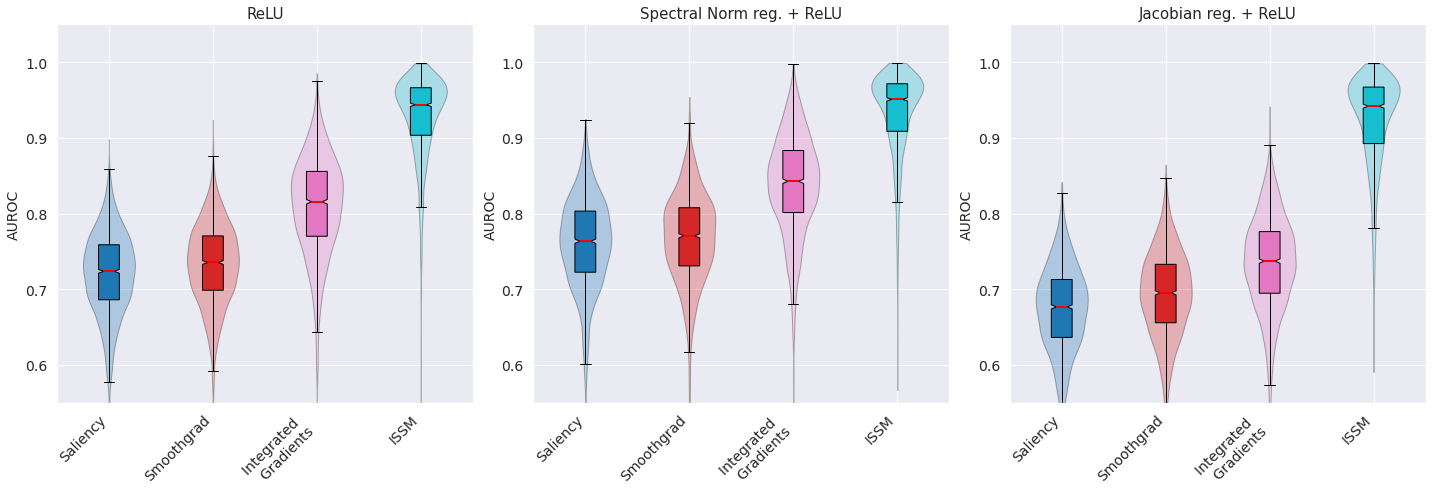

In [49]:
scores = {'Saliency':saliency_roc, 'Smoothgrad':smoothgrad_roc, 'Integrated \n Gradients':intgrad_roc, 'ISSM':mutagenesis_roc}
titles = {'noregmodel':'ReLU', 'snregmodel':'Spectral Norm reg. + ReLU', 'jacregmodel':'Jacobian reg. + ReLU'}
fig = plt.figure(figsize=(20, 7))
for i,model in enumerate(models):
    ax = fig.add_subplot(1,3,i+1)
    modelscores = [score[model] for score in scores.values()]
    ax = tfomics.impress.box_violin_plot(modelscores, ylabel='AUROC', xlabel=scores.keys())
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0], )
    ax.set_ylim([.55,1.05])
    ax.set_title(titles[model], fontsize=15)
fig.tight_layout()

In [2]:
X = tf.random.normal((32, 65, 65,))
x4 = tf.squeeze(tf.gather(X, indices=[4],axis=1))
x46 = tf.squeeze(tf.gather(x4, indices=[6], axis=1))  ## row 4 ; column 6
print(tf.experimental.numpy.all(X[:, 4,6]==x46))

tf.Tensor(True, shape=(), dtype=bool)


In [108]:
x = tf.random.uniform((32,200, 4))
W = tf.Variable(np.random.randn(8,1), dtype=tf.float32)
basis = [tf.math.sin(2*np.pi*i*x) for i in range(4)] + [tf.math.cos(2*np.pi*i*x) for i in range(4)]
basis = tf.stack(basis, axis=-1)
out = tf.squeeze(tf.matmul(basis, W))
x.shape, out.shape

(TensorShape([32, 200, 4]), TensorShape([32, 200, 4]))

In [120]:
class AdaptiveFourier(tfk.layers.Layer):
    def __init__(self, nbasis=2, period=1.,):
        super().__init__(self,)
        self.nbasis = nbasis
        self.period = period
    
    def build(self, input_shape):
        self.W = self.add_weight(
                    shape=(self.nbasis*2,1),
                    initializer=tfk.initializers.glorot_uniform,
                    dtype=tf.float32,
                    trainable=True,
                            )
        self.built = True
    
    def call(self, x, ):
        basis = [tf.math.sin((2*np.pi*i*x)/self.period) for i in range(self.nbasis)] +\
                [tf.math.cos((2*np.pi*i*x)/self.period) for i in range(self.nbasis)]
        basis = tf.stack(basis, axis=-1)
        out = tf.matmul(basis, self.W)
        out = tf.squeeze(out, axis=-1)
        return out

def cnn_dist(
            input_shape, 
            num_labels, 
            nbasis=2,
            period=1.,
            units=[24, 32, 48, 64, 96], 
            dropout=[0.1, 0.2, 0.3, 0.4, 0.5], 
            kernel_regularizer=None,
            logits_only=False,
            name='model',
            ):        
    # input layer
    inputs = tfk.layers.Input(shape=input_shape)

    # layer 1
    nn = tfk.layers.Conv1D(
                        filters=units[0],
                        kernel_size=19,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(inputs)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = AdaptiveFourier(nbasis=nbasis, period=period)(nn)
    nn = tfk.layers.Dropout(dropout[0])(nn)

    nn = tfk.layers.Conv1D(
                        filters=units[1],
                        kernel_size=7,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.Dropout(dropout[1])(nn)
    nn = tfk.layers.MaxPool1D(pool_size=4)(nn)

    # layer 2
    nn = tfk.layers.Conv1D(
                        filters=units[2],
                        kernel_size=5,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.MaxPool1D(pool_size=4)(nn)
    nn = tfk.layers.Dropout(dropout[2])(nn)

    # layer 3
    nn = tfk.layers.Conv1D(
                        filters=units[3],
                        kernel_size=5,
                        strides=1,
                        activation=None,
                        use_bias=True,
                        padding='same',
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.MaxPool1D(pool_size=4)(nn)
    nn = tfk.layers.Dropout(dropout[3])(nn)

    # layer 4 - Fully-connected 
    nn = tfk.layers.Flatten()(nn)
    nn = tfk.layers.Dense(
                        units[4],
                        activation=None,
                        use_bias=True,
                        kernel_regularizer=kernel_regularizer, 
                        )(nn)
    nn = tfk.layers.BatchNormalization()(nn)
    nn = tfk.layers.Activation('relu')(nn)
    nn = tfk.layers.Dropout(dropout[4])(nn)

    # Output layer 
    logits = tfk.layers.Dense(num_labels, name='logits')(nn)
    if logits_only:
        return tfk.Model(inputs, logits, name=name)
    else:
        outputs = tfk.layers.Activation('sigmoid', name='probabilities')(logits)
        return tfk.Model(inputs, outputs, name=name)

In [122]:
# define model
model = cnn_dist(input_shape=(L,A), num_labels=1, logits_only=False, )

# set up optimizer and metrics
acc = tfk.metrics.BinaryAccuracy(name='acc')
auroc = tfk.metrics.AUC(curve='ROC', name='auroc')
aupr = tfk.metrics.AUC(curve='PR', name='aupr')
optimizer = tfk.optimizers.Adam(learning_rate=0.001)
loss = tfk.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
model.compile(optimizer=optimizer, loss=loss, metrics=[acc, auroc, aupr], )

# early stopping callback
es_callback = tfk.callbacks.EarlyStopping(monitor='val_auroc', 
                                            patience=10, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                                factor=0.2,
                                                patience=4, 
                                                min_lr=1e-7,
                                                mode='max',
                                                verbose=1) 

# train model
batchsize = 32
epochs = 100
history = model.fit(dataset['train'].batch(batchsize), 
                            epochs=epochs,
                            validation_data=dataset['valid'].batch(batchsize), 
                            callbacks=[es_callback, reduce_lr])

Epoch 1/100
438/438 [==============================] - 9s 17ms/step - loss: 0.7759 - acc: 0.5006 - auroc: 0.5039 - aupr: 0.5044 - val_loss: 0.6943 - val_acc: 0.4900 - val_auroc: 0.5139 - val_aupr: 0.4992
Epoch 2/100
438/438 [==============================] - 7s 16ms/step - loss: 0.7164 - acc: 0.5012 - auroc: 0.4989 - aupr: 0.4968 - val_loss: 0.6953 - val_acc: 0.4895 - val_auroc: 0.5011 - val_aupr: 0.4864
Epoch 3/100
438/438 [==============================] - 8s 17ms/step - loss: 0.7011 - acc: 0.4974 - auroc: 0.4961 - aupr: 0.4994 - val_loss: 0.6935 - val_acc: 0.4765 - val_auroc: 0.4931 - val_aupr: 0.4863
Epoch 4/100
438/438 [==============================] - 8s 18ms/step - loss: 0.6956 - acc: 0.5070 - auroc: 0.5067 - aupr: 0.5031 - val_loss: 0.6941 - val_acc: 0.4895 - val_auroc: 0.5055 - val_aupr: 0.5007
Epoch 5/100
438/438 [==============================] - 8s 18ms/step - loss: 0.6950 - acc: 0.5067 - auroc: 0.5071 - aupr: 0.5045 - val_loss: 0.6930 - val_acc: 0.5090 - val_auroc: 0.5047

KeyboardInterrupt: 

In [110]:
# nbasis = 2
# period = 1.
    
# fx = tfk.Sequential(
#                 [
#                     tfk.layers.Input((2,)), 
#                     tfkl.Dense(5, activation=AdaptiveFourier(nbasis=nbasis, period=period)),
#                     tfkl.Dense(5, activation=AdaptiveFourier(nbasis=nbasis, period=period)), 
#                     tfkl.Dense(1)
#                 ]
#         )

# x = tf.linspace(0,1,25)
# X1,X2=tf.meshgrid(x,x)
# X1=tf.reshape(X1, (tf.size(X1),))
# X2=tf.reshape(X2, (tf.size(X2),))
# xgrid = tf.stack([X1,X2], axis=1)
# F = fx(xgrid)
# F = tf.reshape(F, (tf.size(x), tf.size(x)))
# X1 = tf.reshape(X1, (tf.size(x), tf.size(x)))
# X2 = tf.reshape(X2, (tf.size(x), tf.size(x)))

# plt.figure(figsize=(10,10))
# ax = plt.axes(projection='3d')
# ax.plot_surface(X1.numpy(),X2.numpy(),F.numpy(), cmap='viridis')
# fig.tight_layout()

In [76]:
tfk.layers.Activation

keras.layers.core.Activation